In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from layers import FFDense
from models import FFNetwork
import utils


c:\Users\karen\myprojects\forward-forward\fwd-fwd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the pretrained CNN (Mobilenet_v2)

In [2]:
module_selection = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

extract_layer = hub.KerasLayer(MODULE_HANDLE,
                              input_shape=IMAGE_SIZE + (3,), 
                              output_shape=[FV_SIZE],
                              trainable=False)
     
extractor = Sequential([extract_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Forward-Forward classifier

In [3]:
class ImageClassifier:
    def __init__(self, extractor, layers, n_classes, learning_rate=0.03):
        self.extractor = extractor
        input_shape = self.extractor.output.shape[1]
        self.layer_list = []
        for i in range(len(layers)):
            shape = input_shape if i == 0 else layers[i-1]
            self.layer_list += [
            FFDense(layers[i], 
                    activation='relu', 
                    input_shape=(shape,))
            ]
        
        self.learning_rate = learning_rate
        self.n_classes = n_classes

    def FF_fit(self, x, y):
        # Make x_pos by concatenating one-hot encoding of class with the latent 
        # image vectors
        y = y.numpy().tolist()
        one_hots = np.array(list(map(lambda x: utils.onehot_encode(x, self.n_classes), y)))
        x_pos = np.hstack([one_hots, x])

        # Make x_neg with shuffled labels
        random_y = tf.random.shuffle(y)
        one_hots = np.array(list(map(lambda x: utils.onehot_encode(x, self.n_classes), random_y)))
        x_neg = np.hstack([one_hots, x])
        
        # pass both through each FFDense layers
        loss_var = []
        for layer in self.layer_list:
            x_pos, x_neg, loss = layer.forward_forward(x_pos, x_neg)
            loss_var.append(loss.numpy())
        mean_res = sum(loss_var) / len(loss_var)
        return mean_res

    def FF_predict(self, x):
        # TBD
        pass

    def fit(self, x_batches, epochs=5):
        history = []
        num_examples = x_batches.reduce(0, lambda x, _: x + 1).numpy()
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}\n[{" " * 20}]', end='')
            losses = []
            count = 1
            start_time = time.time()
            for image_batch, label_batch in x_batches:
                # Generate latent images
                latent_imgs = extractor.predict(image_batch, verbose=0)

                # Pass them through the FFDense layers
                mean_res = self.FF_fit(latent_imgs, label_batch)
                losses.append(mean_res)
                
                percent_done = int(count / num_examples * 100)
                if percent_done > 0 and percent_done % 5 == 0:
                    interval = percent_done // 5
                    print(f'\r[{"=" * interval}{" " * (20-interval)}]', end='')
                count += 1
            mean_losses = sum(losses) / len(losses)
            elapsed = time.time() - start_time
            min = int(elapsed // 60)
            sec = int(elapsed % 60)
            print(f' - time={min}m {sec:02d}s - loss={mean_losses:.4f}')
            history.append(mean_losses)
        return history
    
    def predict(self, x_batches):
        for image_batch, label_batch in x_batches:
            # Generate latent images
            latent_imgs = extractor.predict(image_batch)

            # Do inference through the FFDense layers
            results = self.FF_predict(latent_imgs)
            return results


## Collect data

In [4]:
(raw_train, raw_test), metadata = tfds.load('OxfordIIITPet',
                                            split=['train', 'test'],
                                            with_info=True,
                                            as_supervised=True)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE)

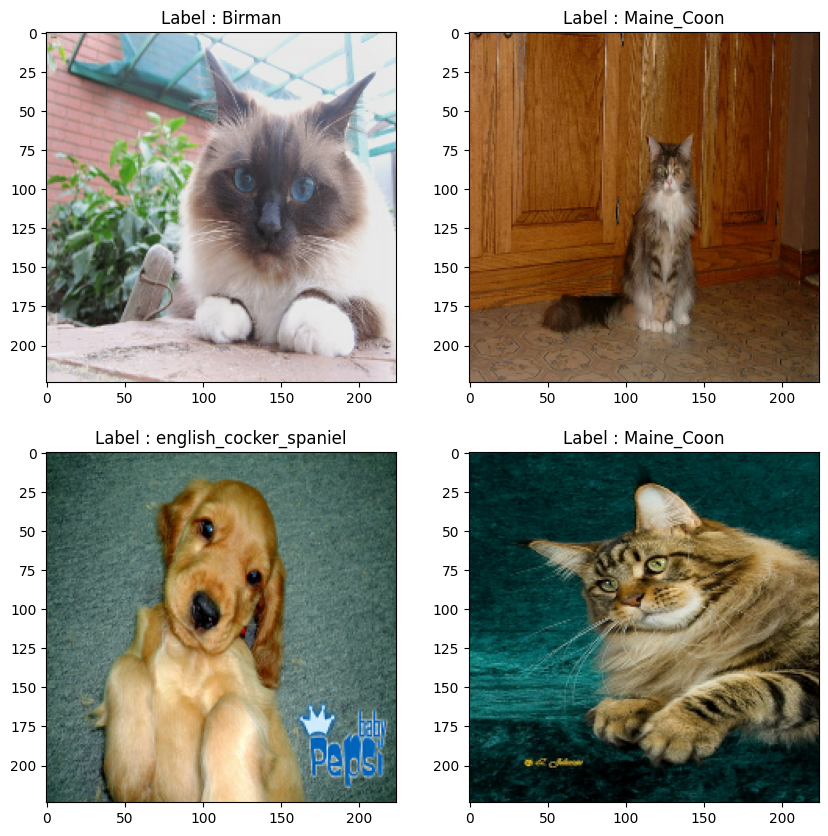

In [5]:
ds = raw_train.take(100)
imgs = []
labels = []
for image, label in tfds.as_numpy(ds):
  image = tf.image.resize(image, (224, 224)) / 255.0
  imgs.append(image)
  labels.append(label)
imgs = np.array(imgs)
labels = np.array(labels)

utils.show_samples(imgs, labels, 4, class_names)

## Train our classifier

In [6]:
clf = ImageClassifier(extractor, [200, 200], len(class_names))
hist = clf.fit(train_batches)

Epoch 1
[====================] - time=4m 22s - loss=0.5700
Epoch 2
[====================] - time=4m 22s - loss=0.4622
Epoch 3
[====================] - time=4m 26s - loss=0.4097
Epoch 4
[====================] - time=4m 33s - loss=0.3781
Epoch 5
[====================] - time=4m 26s - loss=0.3575


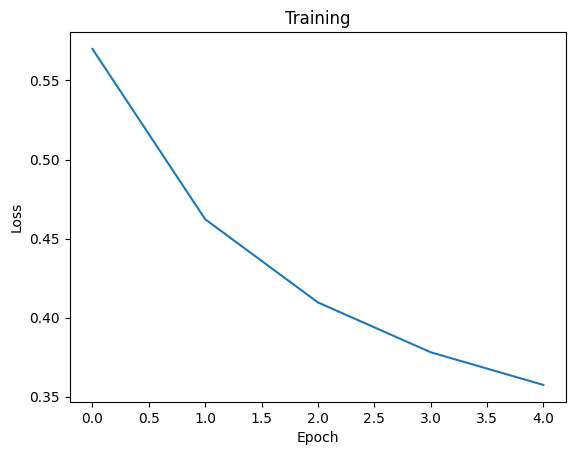

In [7]:
plt.plot(hist)
plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()